In [1]:
import jax.numpy as jnp
import jax
import os

jax.config.update('jax_default_device',jax.devices()[1])
jax.config.update('jax_enable_x64',True)

from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.sindy_model import JSINDyModel
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import LMSolver, AlternatingActiveSetLMSolver
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings


from equinox import tree_pprint
import matplotlib.pyplot as plt

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
from equinox import tree_pprint
from jsindy.kernels import softplus_inverse

In [2]:
noise_var = 18.
dt = 0.08

exp_data = LorenzExp

In [3]:
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel()
optsettings = LMSettings(
    max_iter = 1000,
    min_alpha = 1e-15,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.001,solver_settings=optsettings),
    feature_names=expdata.feature_names
)


In [4]:
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(12.02509627, dtype=float64), 'data_weight': Array(0.08309032, dtype=float64), 'colloc_weight': Array(8.309032, dtype=float64)}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 918.7, gradnorm = 5.399e+05, alpha = 2.5, improvement_ratio = 0.8766
Iteration 1, loss = 187.0, gradnorm = 9.067e+05, alpha = 2.083, improvement_ratio = 0.8226
Iteration 2, loss = 65.74, gradnorm = 9.291e+05, alpha = 2.083, improvement_ratio = 0.7555
Iteration 3, loss = 33.68, gradnorm = 5.473e+05, alpha = 1.736, improvement_ratio = 0.8102
Iteration 4, loss = 27.67, gradnorm = 1.139e+05, alpha = 1.736, improvement_ratio = 0.6575
Iteration 5, loss = 23.98, gradnorm = 1.548e+05, alpha = 1.447, improvement_ratio = 0.9283
Iteration 200, loss = 19.41, gradnorm = 3.231e-07, alpha = 104.2, improvement_ratio = inf
Line Search Failed!
Final Iteration Results
Iteration 250, loss = 19.41, gradnorm = 2.189e-07, alpha = 3.464e+05, improvement_ratio = -5.0
Model after smooth warm start
(x)' = -3.498 1 + -1.680 x + 7.035 y + 1.362 z + 0.346 x^2 + -0.421 x y + -0.209 x z + 0.176 y^2 + 0.026 y z + -0.059 z^2
(y)' = -2.431 1 + 18.753 x + 3.057 y + -0.678 z + -0.967 x^2 + 1.205 x y + 

In [5]:
model.print()

(x)' = 5.066 1 + -11.858 x + 11.480 y
(y)' = 24.750 x + -0.923 x z
(z)' = 3.750 1 + 0.530 x + -2.887 z + 0.908 x y


In [6]:
from jsindy.util import full_data_initialize
z0,theta0 = full_data_initialize(
            model.t,
            model.x,
            model.traj_model,
            model.dynamics_model,
            sigma2_est=model.params["sigma2_est"]+0.01
            )

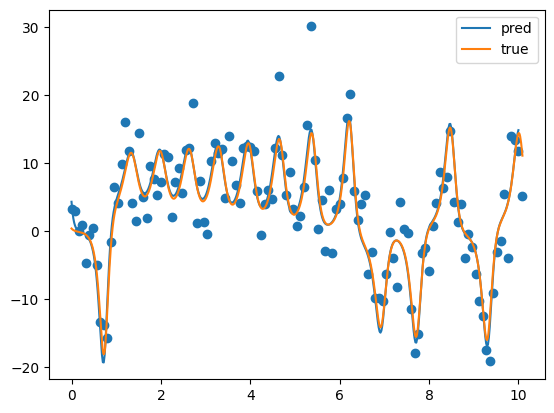

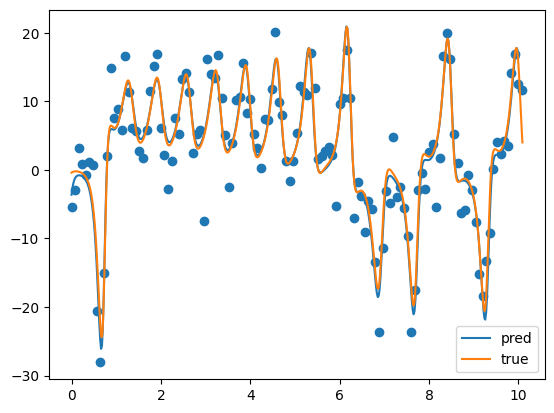

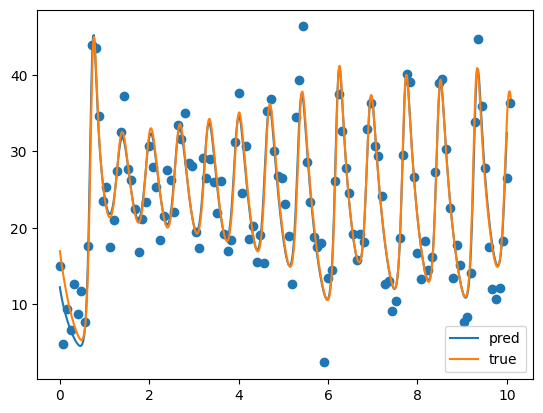

In [7]:
tgrid = jnp.linspace(0,10,500)
xpred = model.predict_state(tgrid)


for index in range(3):
    plt.plot(tgrid,xpred[:,index],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,index],label = 'true')

    plt.scatter(expdata.t_train,expdata.x_train[:,index])
    plt.legend()
    plt.show()

In [8]:
metrics

{'coeff_mets': {'precision': 0.6666666666666666,
  'recall': 0.8571428571428571,
  'f1': 0.75,
  'coeff_rel_l2': 0.24002020666583465,
  'coeff_rmse': 1.3816709990442337,
  'coeff_mae': 0.5773921091650017},
 'data_mets': {'mse': Array(60.65850081, dtype=float64),
  'rmse': np.float64(7.788356746138626),
  'mae': np.float64(4.946715234842313),
  'max_abs_error': np.float64(49.643042017802884),
  'normalized_mse': Array(0.01559206, dtype=float64),
  'relative_l2_error': np.float64(0.12484827234943031)}}